# Quantum-Classical Hybrid Machine Learning

Quantum-classical hybrid machine learning is a kind of NISQ algorithm for machine learning using a quantum computer.  
As the name suggests, it uses a quantum computer and a classical computer hybridly.

The basic idea is the same as VQE and QAOA.  
The quantum computer and the classical computer are run alternately, and the parameter $\theta$ that the quantum circuit has is repeatedly updated to minimize (maximize) the target quantity.
The calculation to find the updated values of parameters is done by the classical computer.   

Classical computer performs the calculations that are possible with classical calculations, and by keeping the parameters as classical data, the quantum circuit can be initialized and executed repeatedly.
This reduces the size of the quantum circuit and makes it suitable for execution on NISQ devices.

VQE and QAOA defined a Hamiltonian for the problem, and updated the parameters of the quantum circuit so that the expected value of the Hamiltonian is minimum (maximum). In contrast, in quantum-classical hybrid machine learning, a loss function that takes the measurement results of the quantum circuit as its argument is defined in the classical computer side. 
As a post-processing step, the classical computer calculates the output of the loss function and updates the parameters to minimize the loss function.  
This eliminates the need to define a Hamiltonian and allows us to directly apply the loss function, which is widely used in machine learning.  

The quantum circuitry that runs in a quantum computer can be divided into three major parts.  

First, in the "Data encoding" layer, the input data for training is embedded into the quantum circuit.  
Next, the "Parametric quantum circuit" layer consists of a combination of two qubit gates to entangle and a rotational gate to update the parameters. It is in this part that the probability distribution of the model is learned by updating parameters.  
Finally, the "Measurement" layer measures the quantum state and passes the measurement results to the classical computer.

Learning the parameters $\theta$ of a quantum circuit is similar to learning the weight parameters in a conventional neural network.  
Therefore, the elements necessary for successful learning are similar to those of neural networks, for example,

1. How to embed data
2. Loss function design
3. Parameter update method
4. Parametric quantum circuit (learning layer) design

A variety of methods have been proposed and used for each of these.  
In the following tutorials, we will show some simple learning examples using concrete models.

### References

Benedetti, Marcello, et al. "Parameterized quantum circuits as machine learning models." Quantum Science and Technology 4.4 (2019): 043001.

## Numerical differentiation
From the function $f(x)$ and the small change $h$, the derivative can be obtained numerically.

$$
\frac{df(x)}{dx} = \lim_{h \rightarrow 0}\frac{f(x+h) - f(x)}{h}
$$

For example, with $f(x) = x^2$, $h=0.1$, the derivative at $x=1$ is as follows

In [1]:
x = 1
h = 0.1
((x+h)**2 - x**2) / h

2.100000000000002

## Partial differentiation
In the parameterized quantum circuits often used in NISQ, many angles appear in the circuit as variable parameters.  
Partial differentiation allows you to find the differential coefficient at a particular parameter.

Partial derivative of $f(x, y)$ with respect to $x$.

$$
\frac{\partial f(x,y)}{\partial x}
$$

Partial derivative of $f(x, y)$ with respect to $y$.

$$
\frac{\partial f(x,y)}{\partial y}
$$

## Gradient
The gradient is the partial derivative for each parameter written in the form of a vector.

$$
(\frac{\partial f(x,y)}{\partial x},\frac{\partial f(x,y)}{\partial y})
$$

The gradient is useful for finding the point where the function takes its minimum value (minimum point, minima).  
The derivative becomes zero at the minima, and the points around them (neighborhoods) have positive or negative slopes.

- If the coordinates of the current location is greater than the minimum point, the slope is positive. Therefore, subtracting the slope from the current location coordinates will bring you closer to the minimum point.
- If the coordinate of the current location is less than the minimum point, the slope is negative. So again, subtracting the slope from the current location coordinates will bring you closer to the minimum point.

From the above, we can find the minimum point by updating the current location using the gradient. The $e$ denotes the learning rate here.

$$
x' = x -e\cdot\frac{\partial f(x,y)}{\partial x}\\
y' = y -e\cdot\frac{\partial f(x,y)}{\partial y}
$$

Repeat this process.

## Gradient descent
Let's try VQE with a circuit using RY gates to find the minimum expected value of a measurement.

3.1410499059502546


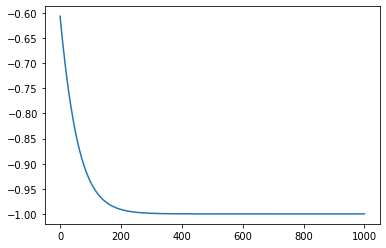

In [8]:
from blueqat import Circuit
from blueqat.pauli import Z
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Z expectation value
def exptZ(a):
    return Circuit().ry(a)[0].run(hamiltonian=1*Z[0])

# Initail setting
ainit = [np.random.rand()*2*np.pi]
a = ainit.copy()
h = 0.001
e = 0.01

# Update and logging of gradient
for i in range(1000):
    a.append(a[i] - e*(exptZ(a[i]+h) - exptZ(a[i]))/h)

# Last value
print(a[-1])

# Plot expectation value
plt.plot(list(map(exptZ, a)))
plt.show()

The $Z$ measurement expectation value of one qubit is minimized when the state is $\lvert 1\rangle$.  
After minimizing the expectation value, the $RY$ gate rotation angle is approximately $\pi = 3.14... $, which changes the initial state $\lvert 0\rangle$ to $\lvert 1\rangle$.  
From the above, we succeeded VQE.

## Parameter shift rule

Reference: arXiv:1803.00745 [quant-ph] (https://arxiv.org/abs/1803.00745)

Numerical differentiation with a small numerical value $h$ has a problem in running on a real quantum computer.  
The expected value computed by a quantum computer has variance due to sampling and noise. If the small numerical value $h$ is too small, it will be buried in those variance, and if it is too large, the numerical differentiation will be inaccurate. Therefore, it is necessary to adjust $h$ as a hyperparameter.

Against this background, research is also being conducted on methods for calculating the gradient in quantum computers.  
Here we explain a typical method, "parameter shift rule".

Think about $\langle \hat{B}\rangle$, expected value of an observable $\hat{B}$.  
For the parameter $\theta$ in the Pauli rotation gate $U(\theta) = \exp{(-i\theta P)}\ (P\in \{X, Y, Z, I\})$, the gradient of $\langle \hat{B}\rangle$ is obtained as follows  


$$\frac{\partial \langle \hat{B}\rangle}{\partial \theta} = \frac{1}{2} \bigl(\langle \hat{B}\rangle_+ - \langle \hat{B}\rangle_- \bigr)$$

$$U(\theta + \frac{\pi}{2}) = \langle \hat{B}\rangle_+$$
$$U(\theta - \frac{\pi}{2}) = \langle \hat{B}\rangle_-$$

In other words, for each parameter for which you want to find the gradient, it's sufficinet to run the $+\frac{\pi}{2}$ and $-\frac{\pi}{2}$ shifted quantum circuits and calculate the expected value, respectively.  
Since this method uses a fixed and sufficiently large shift $\pm\frac{\pi}{2}$ instead of a small change $h$, the above issue can be solved.  

This can be applied to parameters $\theta$ of, such as, $RX(\theta)$ gate, $RY(\theta)$ gate, and $RZ(\theta)$ gate. By combining this with a two-qubit entangle gate, it is possible to construct a general quantum-classical hybrid machine learning circuit.

The following is an example of the gradient descent method calculation from earlier again using the parameter shift rule.

3.141773808322522


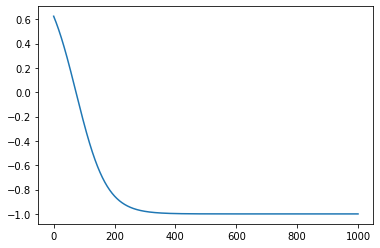

In [4]:
# Initail setting
ainit = [np.random.rand()*2*np.pi]
a = ainit.copy()
e = 0.01

# Update and logging of gradient
for i in range(1000):
    grad = (exptZ(a[i]+np.pi/2) - exptZ(a[i]-np.pi/2)) / 2
    a.append(a[i] - e*grad)

# Last value
print(a[-1])

# Plot expectation value
plt.plot(list(map(exptZ, a)))
plt.show()

## Loss function
VQE minimizes the expected value of measurement, but in the above approach, the object of minimization does not necessarily have to be the expected value of measurement.  
Here we will use the more general loss function. This way we can recognize it as machine learning.

3.3592089822562348


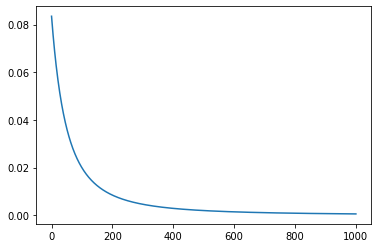

0.00055625863704992


In [5]:
from blueqat import Circuit
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# expectation value
def expt(a):
    return Circuit().ry(a)[0].run(hamiltonian=1*Z[0])

# loss function
def loss(res,tar):
    return np.square(res-tar)

# derivative
def dfx(a,h,tgt=-1):
    return (loss(expt(a+h),tgt) - loss(expt(a),tgt))/h
#    return (expt(a+h)-expt(a))/h

# gradient
def grad(a,h,e):
    for i in range(1000):
        a.append(a[i] - e*dfx(a[i],h))
    return a

# initialize
a = [np.random.rand()*2*np.pi]
h = 0.001
e = 0.01

ra = grad(a,h,e)
print(ra[-1])

arr = [loss(expt(i),-1) for i in ra]

plt.plot(arr)
plt.show()

print(arr[-1])

## momentum SGD

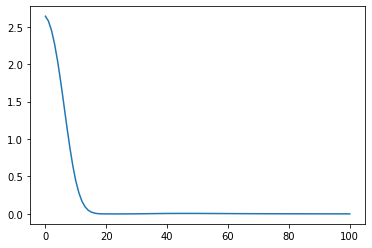

In [6]:
#momentum sgd
def msgd(a,h,e,tgt,alpha):
    p_delta = 0
    for i in range(100):
        update = -e*dfx(a[i],h,tgt) + alpha*p_delta
        a.append(a[i] + update)
        p_delta = update
    return a

#initialization
a = ainit.copy()
h = 0.001
e = 0.01

alpha = 0.9
tgt = -1

result = msgd(a,h,e,tgt,alpha)
arr = [loss(expt(i),tgt) for i in result]

plt.plot(arr)
plt.show()

## Adagrad

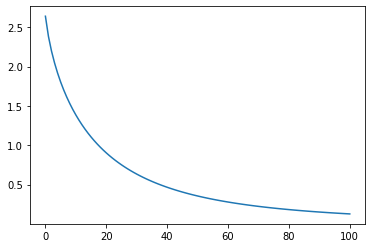

In [7]:
def adagrad(a,h,e,tgt,epsilon):
    G = epsilon
    for i in range(100):
        g = dfx(a[i],h,tgt)
        G += g*g
        update = -e/np.sqrt(G)*g
        a.append(a[i] + update)
    return a

#initialization
a = ainit.copy()
h = 0.001
e = 0.1
epsilon = 1e-08
tgt = -1

result = adagrad(a,h,e,tgt,epsilon)
arr = [loss(expt(i),tgt) for i in result]

plt.plot(arr)
plt.show()